In [1]:
import math
import numbers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
%cd ..

/Users/yg/code/github/DS-GA-1013-Project


In [3]:
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))
        kernel = kernel.double()
        print(kernel.shape)

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

In [4]:
sigma = 0.001
smoothing = GaussianSmoothing(3, 5, sigma)

torch.Size([3, 1, 5, 5])


In [5]:
def load_png(file_name):
    with open(file_name,'rb') as f:
        img = Image.open(f).convert("RGB")
        image = np.asarray(img)
    return image

In [6]:
img = load_png("../neumann_networks_code/testing_data/cifar/0_cat.png")
img = img / 255.0
transp_img = np.transpose(img, (2,0,1))[np.newaxis,...]
tensor_img = torch.from_numpy(transp_img).double()

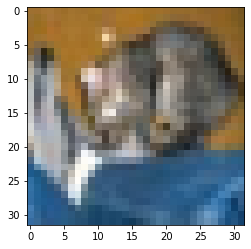

In [7]:
imgplot = plt.imshow(img)
plt.show()

In [8]:
output = smoothing(tensor_img)
output = np.transpose(np.squeeze(output), (1,2,0))
output.shape

torch.Size([28, 28, 3])

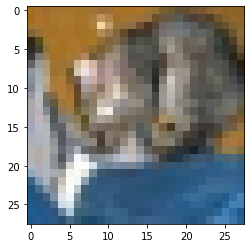

In [9]:
imgplot = plt.imshow(output)
plt.show()

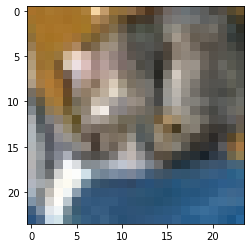

In [10]:
output = smoothing(tensor_img)
output = smoothing(output)
output = np.transpose(np.squeeze(output), (1,2,0))
imgplot = plt.imshow(output)
plt.show()

In [11]:
def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/(g.sum())

batch_size = 32
dimension1 = 32
dimension2 = 32
color_dimension = 3

blur_kernel = fspecial_gauss(size=5, sigma=sigma)
blur_kernel_repeat = blur_kernel.reshape((5, 5, 1, 1))
blur_kernel_repeat = np.repeat(blur_kernel_repeat, color_dimension, axis=2)
blur_kernel_repeat = np.transpose(blur_kernel_repeat, (2,3,0,1))
blur_kernel = torch.from_numpy(blur_kernel_repeat).double()
blur_kernel.shape

torch.Size([3, 1, 5, 5])

In [38]:
def blur_model(channels=3, weight=blur_kernel):
    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=5, groups=channels, bias=False)
    gaussian_filter.weight.data = weight
    gaussian_filter.weight.requires_grad = False
    return gaussian_filter

In [39]:
blur_filter = blur_model()

In [40]:
blurred_output = blur_filter(tensor_img).numpy()
blurred_output = np.transpose(np.squeeze(blurred_output), (1,2,0))

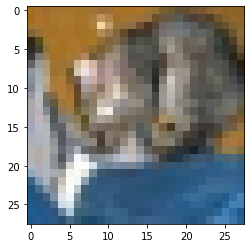

In [41]:
imgplot = plt.imshow(blurred_output)
plt.show()

In [42]:
def blur_gramian():
    return blur_model(blur_model())

In [43]:
gramian_output = blur_filter(tensor_img)
gramian_output = blur_filter(gramian_output).numpy()
gramian_output = np.transpose(np.squeeze(gramian_output), (1,2,0))

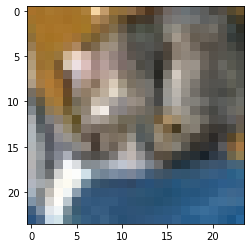

In [44]:
imgplot = plt.imshow(gramian_output)
plt.show()

In [57]:
def add_noise(img, sigma):
    noisy_img = img + np.random.normal(loc=0.0, scale=sigma, size=img.shape)
    noisy_img = np.clip(noisy_img, 0.0, 1.0)
    return noisy_img

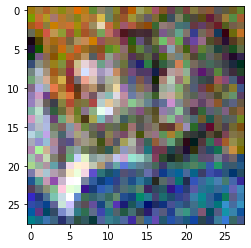

In [60]:
noisy_img = add_noise(blurred_output, 0.1)
plt.imshow(noisy_img)
plt.show()